<a href="https://www.kaggle.com/omarhisham19/credit-card-approval-prediction?scriptVersionId=87371754" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [12]:
!pip install pycaret

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as mso
import seaborn as sns
import pycaret

from pycaret.classification import *

warnings.filterwarnings('ignore') 

     |████████████████████████████████| 301 kB 3.2 MB/s            
     |████████████████████████████████| 25.9 MB 39.5 MB/s            
     |████████████████████████████████| 24.2 MB 40.2 MB/s            
     |████████████████████████████████| 114 kB 42.8 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 167 kB 65.1 MB/s            
     |████████████████████████████████| 10.4 MB 30.0 MB/s            
     |████████████████████████████████| 15.6 MB 36.6 MB/s            
     |████████████████████████████████| 636 kB 60.2 MB/s            
     |████████████████████████████████| 184 kB 66.3 MB/s            
     |████████████████████████████████| 1.0 MB 61.9 MB/s            
     |████████████████████████████████| 14.8 MB 39.2 MB/s            
     |████████████████████████████████| 79 kB 6.1 MB/s             
     |████████████████████████████████| 58 kB 4.3 MB/s             
  Preparing metadata (setup.py) ... done
  Created wheel for

# Data Loading

In [13]:
app_df = pd.read_csv('/kaggle/input/credit-card-approval-prediction/application_record.csv')

In [14]:
app_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


### Exploration

In [15]:
app_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [16]:
app_df = app_df.sort_values('ID')
app_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423317,7999660,F,N,N,0,90000.0,State servant,Higher education,Single / not married,House / apartment,-13432,-5446,1,0,0,0,Core staff,1.0
426434,7999696,F,N,Y,2,135000.0,State servant,Secondary / secondary special,Married,House / apartment,-12576,-4382,1,0,0,0,Medicine staff,4.0
432885,7999738,M,N,Y,0,180000.0,Working,Secondary / secondary special,Married,House / apartment,-9970,-119,1,0,0,0,NaN,2.0
421225,7999784,F,Y,Y,1,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-10630,-454,1,0,0,0,NaN,3.0


In [17]:
app_df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,438557.0,6.022176e+06,571637.023257,5008804.0,5609375.0,6047745.0,6456971.0,7999952.0
CNT_CHILDREN,438557.0,4.273903e-01,0.724882,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,438557.0,1.875243e+05,110086.853066,26100.0,121500.0,160780.5,225000.0,6750000.0
DAYS_BIRTH,438557.0,-1.599790e+04,4185.030007,-25201.0,-19483.0,-15630.0,-12514.0,-7489.0
DAYS_EMPLOYED,438557.0,6.056368e+04,138767.799647,-17531.0,-3103.0,-1467.0,-371.0,365243.0
FLAG_MOBIL,438557.0,1.000000e+00,0.000000,1.0,1.0,1.0,1.0,1.0
FLAG_WORK_PHONE,438557.0,2.061328e-01,0.404527,0.0,0.0,0.0,0.0,1.0
FLAG_PHONE,438557.0,2.877710e-01,0.452724,0.0,0.0,0.0,1.0,1.0
FLAG_EMAIL,438557.0,1.082071e-01,0.310642,0.0,0.0,0.0,0.0,1.0
CNT_FAM_MEMBERS,438557.0,2.194465e+00,0.897207,1.0,2.0,2.0,3.0,20.0


### The number of non-duplicate rows is less than the whole data (some records are duplicated)

In [18]:
app_df.drop_duplicates(subset=['ID']).count()

ID                     438510
CODE_GENDER            438510
FLAG_OWN_CAR           438510
FLAG_OWN_REALTY        438510
CNT_CHILDREN           438510
AMT_INCOME_TOTAL       438510
NAME_INCOME_TYPE       438510
NAME_EDUCATION_TYPE    438510
NAME_FAMILY_STATUS     438510
NAME_HOUSING_TYPE      438510
DAYS_BIRTH             438510
DAYS_EMPLOYED          438510
FLAG_MOBIL             438510
FLAG_WORK_PHONE        438510
FLAG_PHONE             438510
FLAG_EMAIL             438510
OCCUPATION_TYPE        304318
CNT_FAM_MEMBERS        438510
dtype: int64

In [19]:
app_df.drop_duplicates(subset=['ID'], keep='last', inplace=True)

# EDA

### Some values of CNT_CHILDREN and AMT_INCOME_TOTAL are way above the mean 15 children and 6 million per year!

<Figure size 720x720 with 0 Axes>

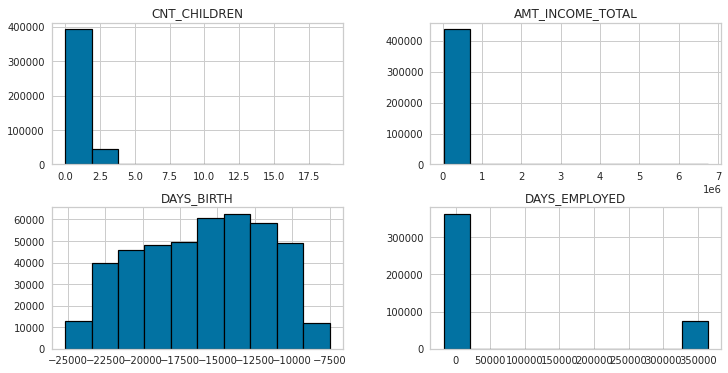

In [20]:
plt.figure(figsize=(10,10))

cols_to_plot = ["CNT_CHILDREN","AMT_INCOME_TOTAL","DAYS_BIRTH","DAYS_EMPLOYED"]
app_df[cols_to_plot].hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,6)

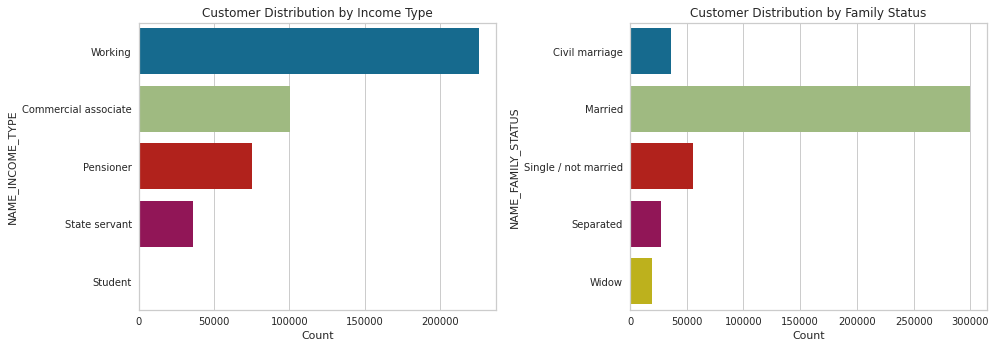

In [21]:
fig, axes = plt.subplots(1,2)

g1=sns.countplot(y=app_df.NAME_INCOME_TYPE,linewidth=1.2, ax=axes[0])
g1.set_title("Customer Distribution by Income Type")
g1.set_xlabel("Count")

g2=sns.countplot(y=app_df.NAME_FAMILY_STATUS,linewidth=1.2, ax=axes[1])
g2.set_title("Customer Distribution by Family Status")
g2.set_xlabel("Count")

fig.set_size_inches(14,5)

plt.tight_layout()


plt.show()

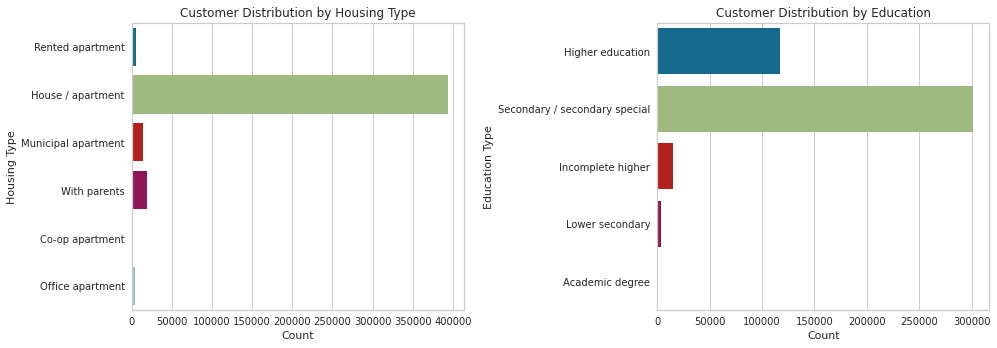

In [22]:
fig, axes = plt.subplots(1,2)

g1= sns.countplot(y=app_df.NAME_HOUSING_TYPE,linewidth=1.2, ax=axes[0])
g1.set_title("Customer Distribution by Housing Type")
g1.set_xlabel("Count")
g1.set_ylabel("Housing Type")

g2= sns.countplot(y=app_df.NAME_EDUCATION_TYPE, ax=axes[1])
g2.set_title("Customer Distribution by Education")
g2.set_xlabel("Count")
g2.set_ylabel("Education Type")

fig.set_size_inches(14,5)

plt.tight_layout()

plt.show()

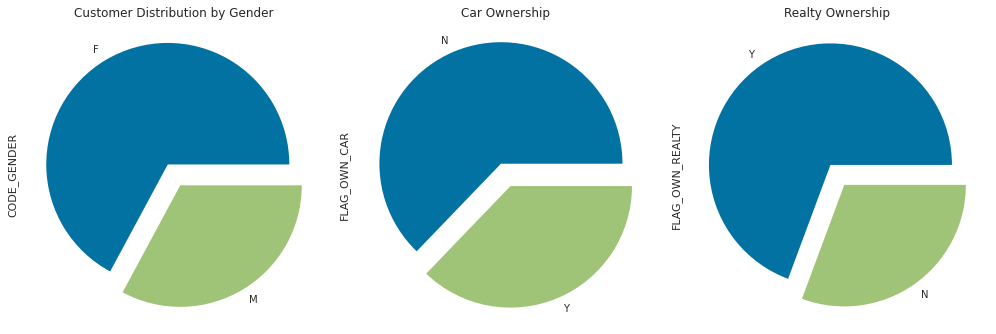

In [23]:
fig, axes = plt.subplots(1,3)

g1= app_df['CODE_GENDER'].value_counts().plot.pie(explode=[0.1,0.1], ax=axes[0])
g1.set_title("Customer Distribution by Gender")

g2= app_df['FLAG_OWN_CAR'].value_counts().plot.pie(explode=[0.1,0.1], ax=axes[1])
g2.set_title("Car Ownership")

g3= app_df['FLAG_OWN_REALTY'].value_counts().plot.pie(explode=[0.1,0.1], ax=axes[2])
g3.set_title("Realty Ownership")

fig.set_size_inches(14,5)

plt.tight_layout()

plt.show()

# Preprocessing

### Converting categorical values to ones and zeros (can be done automatically by PyCaret)

In [24]:
app_df['CODE_GENDER'].unique()

array(['M', 'F'], dtype=object)

In [25]:
app_df = app_df.replace({'CODE_GENDER' :
                                         {'M' : 1,
                                          'F' : 0}})

In [26]:
app_df['FLAG_OWN_CAR'].unique()

array(['Y', 'N'], dtype=object)

In [27]:
app_df = app_df.replace({'FLAG_OWN_CAR' :
                                         {'Y' : 1,
                                          'N' : 0}})

In [28]:
app_df['FLAG_OWN_REALTY'].unique()

array(['Y', 'N'], dtype=object)

In [29]:
app_df = app_df.replace({'FLAG_OWN_REALTY' :
                                            {'Y' : 1,
                                             'N' : 0}})

In [30]:
app_df['NAME_EDUCATION_TYPE'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [31]:
app_df['NAME_FAMILY_STATUS'].unique()

array(['Civil marriage', 'Married', 'Single / not married', 'Separated',
       'Widow'], dtype=object)

In [32]:
app_df['CNT_FAM_MEMBERS'] = app_df['CNT_FAM_MEMBERS'].astype(int)

### Converting the number of days format in DAYS_BIRTH and DAYS_EMPLOYED to number of years

In [33]:
# Using pandas timedelta type which eases the conversion to datetime format and years calculation
app_df['AGE'] = np.ceil(pd.to_timedelta(app_df['DAYS_BIRTH'], unit='D').dt.days / -365.25)

In [34]:
app_df['AGE'].unique()

array([33., 59., 53., 62., 47., 49., 30., 52., 28., 31., 35., 57., 44.,
       45., 46., 34., 56., 43., 38., 29., 58., 55., 40., 25., 21., 39.,
       41., 37., 36., 42., 60., 27., 51., 54., 63., 61., 64., 26., 23.,
       24., 65., 48., 32., 50., 66., 22., 67., 68., 69.])

In [35]:
# values greater than zero means that the applicant doesn't work
app_df.loc[(app_df['DAYS_EMPLOYED'] > 0), 'DAYS_EMPLOYED'] = 0

In [36]:
app_df['YEARS_EMPLOYED'] = np.ceil(pd.to_timedelta(app_df['DAYS_EMPLOYED'], unit='D').dt.days / -365.25)

In [37]:
app_df['YEARS_EMPLOYED'].unique()

array([13.,  4.,  9., -0.,  3.,  5.,  6., 20., 15., 14.,  8.,  7., 18.,
       30.,  2., 16., 12.,  1., 11., 24., 25., 21., 10., 28., 27., 19.,
       22., 23., 17., 29., 39., 33., 32., 37., 38., 31., 40., 26., 35.,
       34., 42., 41., 36., 44., 43., 45., 48., 46.])

### Removing outliers by calculating z-scores and removing records with values greater than 3.5

In [38]:
def calculate_z_scores(df, cols):
    for col in cols:
        df[col+"_z_score"] = (df[col] - df[col].mean())/df[col].std()
    return df

app_df_2 = calculate_z_scores(app_df, cols=["CNT_CHILDREN","AMT_INCOME_TOTAL", "YEARS_EMPLOYED"])


filter_2 = app_df_2.CNT_CHILDREN_z_score.abs() <= 3.5
filter_3 = app_df_2.AMT_INCOME_TOTAL_z_score.abs() <= 3.5
filter_4 = app_df_2.YEARS_EMPLOYED_z_score.abs() <= 3.5

app_df_2 = app_df_2[filter_2 & filter_3 & filter_4]

app_df_2.drop(columns= ["CNT_CHILDREN_z_score","AMT_INCOME_TOTAL_z_score","YEARS_EMPLOYED_z_score"],inplace=True)

### Removing records that contain null values

In [39]:
app_clean_df = app_df_2[app_df_2['OCCUPATION_TYPE'].notna()]

### Renaming columns and dropping redundant features

In [40]:
app_clean_df = app_clean_df.drop(columns=['DAYS_BIRTH', 'DAYS_EMPLOYED'])

In [41]:
app_clean_df.columns = ['ID', 'Gender', 'Owned_Car', 'Owned_Realty', 'Total_Children', 'Total_Income', 'Income_Type',\
                        'Education_Type', 'Family_Status', 'Housing_Type', 'Owned_Mobile_Phone', 'Owned_Work_Phone', \
                        'Owned_Phone', 'Owned_Email', 'Job_Title', 'Total_Family_Members', 'Age', 'Years_Experience' ]

### Loading the 2nd csv file

In [42]:
credit_df = pd.read_csv('/kaggle/input/credit-card-approval-prediction/credit_record.csv')

In [43]:
credit_df = credit_df.sort_values('ID')

In [44]:
credit_df

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
22,5001712,-18,0
...,...,...,...
1048547,5150487,-2,C
1048546,5150487,-1,C
1048545,5150487,0,C
1048558,5150487,-13,C


In [45]:
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 32.0+ MB


In [46]:
credit_df['STATUS2'] = credit_df['STATUS']

In [47]:
credit_df['STATUS2'].unique()

array(['X', '0', 'C', '1', '3', '2', '4', '5'], dtype=object)

### Replacing C, X, 0 with 'Good_Debt' (C: loan for that month is already paid; X: no loan for that month; 0: loan is 1 to 29 days overdue).
### Similarly 1, 2, 3, 4, 5 with 'Bad_Debt' (1: loan is 30 to 59 days overdue; 2: loan is 60 to 89 days overdue; 3: loan is 90 to 119 days overdue;
###                                          4: loan is 120 to 149 days overdue; 5: loan is more than 150 days overdue).

In [48]:
credit_df = credit_df.replace({'STATUS2' :
                                          {'C' : 'Good_Debt',
                                           'X' : 'Good_Debt',
                                           '0' : 'Good_Debt',
                                           '1' : 'Bad_Debt',
                                           '2' : 'Bad_Debt',
                                           '3' : 'Bad_Debt',
                                           '4' : 'Bad_Debt',
                                           '5' : 'Bad_Debt'}})

### Counting the number of good and bad debts per client ID

In [49]:
credit_df.value_counts(subset=['ID', 'STATUS2']).unstack(fill_value=0)

STATUS2,Bad_Debt,Good_Debt
ID,,
5001711,0,4
5001712,0,19
5001713,0,22
5001714,0,15
5001715,0,60
...,...,...
5150482,0,18
5150483,0,18
5150484,0,13


In [50]:
result_df = credit_df.value_counts(subset=['ID', 'STATUS2']).unstack(fill_value=0).reset_index()

In [51]:
result_df

STATUS2,ID,Bad_Debt,Good_Debt
0,5001711,0,4
1,5001712,0,19
2,5001713,0,22
3,5001714,0,15
4,5001715,0,60
...,...,...,...
45980,5150482,0,18
45981,5150483,0,18
45982,5150484,0,13
45983,5150485,0,2


# Classifing clients with good_debt counts greater than bad_debt as eligible and vice-versa

In [52]:
result_df.loc[(result_df['Good_Debt'] > result_df['Bad_Debt']), 'Status'] = 1

In [53]:
result_df.loc[(result_df['Good_Debt'] <= result_df['Bad_Debt']), 'Status'] = 0

In [54]:
result_df['Status'] = result_df['Status'].astype(int)

In [55]:
result_df

STATUS2,ID,Bad_Debt,Good_Debt,Status
0,5001711,0,4,1
1,5001712,0,19,1
2,5001713,0,22,1
3,5001714,0,15,1
4,5001715,0,60,1
...,...,...,...,...
45980,5150482,0,18,1
45981,5150483,0,18,1
45982,5150484,0,13,1
45983,5150485,0,2,1


In [56]:
df = app_clean_df.merge(result_df, how='inner', on=['ID'])

In [57]:
df.head()

,ID,Gender,Owned_Car,Owned_Realty,Total_Children,Total_Income,Income_Type,Education_Type,Family_Status,Housing_Type,Owned_Mobile_Phone,Owned_Work_Phone,Owned_Phone,Owned_Email,Job_Title,Total_Family_Members,Age,Years_Experience,Bad_Debt,Good_Debt,Status
0,5008806,1,1,1,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2,59.0,4.0,0,30,1
1,5008808,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1,53.0,9.0,0,5,1
2,5008809,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1,53.0,9.0,0,5,1
3,5008810,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1,53.0,9.0,0,27,1
4,5008811,0,0,1,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1,53.0,9.0,0,39,1


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24180 entries, 0 to 24179
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    24180 non-null  int64  
 1   Gender                24180 non-null  int64  
 2   Owned_Car             24180 non-null  int64  
 3   Owned_Realty          24180 non-null  int64  
 4   Total_Children        24180 non-null  int64  
 5   Total_Income          24180 non-null  float64
 6   Income_Type           24180 non-null  object 
 7   Education_Type        24180 non-null  object 
 8   Family_Status         24180 non-null  object 
 9   Housing_Type          24180 non-null  object 
 10  Owned_Mobile_Phone    24180 non-null  int64  
 11  Owned_Work_Phone      24180 non-null  int64  
 12  Owned_Phone           24180 non-null  int64  
 13  Owned_Email           24180 non-null  int64  
 14  Job_Title             24180 non-null  object 
 15  Total_Family_Member

<AxesSubplot:>

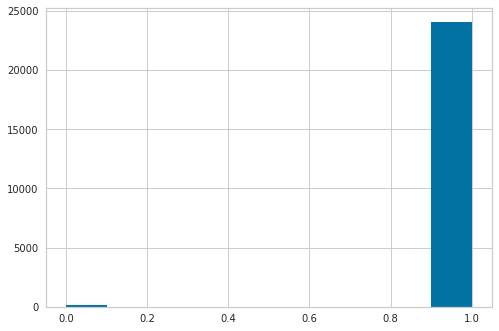

In [59]:
df['Status'].hist()

In [60]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,24180.0,5.078814e+06,41990.189298,5008806.0,5042226.75,5078978.5,5115621.5,5150487.0
Gender,24180.0,3.800662e-01,0.485413,0.0,0.00,0.0,1.0,1.0
Owned_Car,24180.0,4.179074e-01,0.493225,0.0,0.00,0.0,1.0,1.0
Owned_Realty,24180.0,6.525227e-01,0.476179,0.0,0.00,1.0,1.0,1.0
Total_Children,24180.0,4.710918e-01,0.686008,0.0,0.00,0.0,1.0,2.0
Total_Income,24180.0,1.891670e+05,85107.281941,27000.0,135000.00,180000.0,225000.0,562500.0
Owned_Mobile_Phone,24180.0,1.000000e+00,0.000000,1.0,1.00,1.0,1.0,1.0
Owned_Work_Phone,24180.0,2.748139e-01,0.446430,0.0,0.00,0.0,1.0,1.0
Owned_Phone,24180.0,2.922250e-01,0.454795,0.0,0.00,0.0,1.0,1.0
Owned_Email,24180.0,1.005790e-01,0.300777,0.0,0.00,0.0,0.0,1.0


<AxesSubplot:>

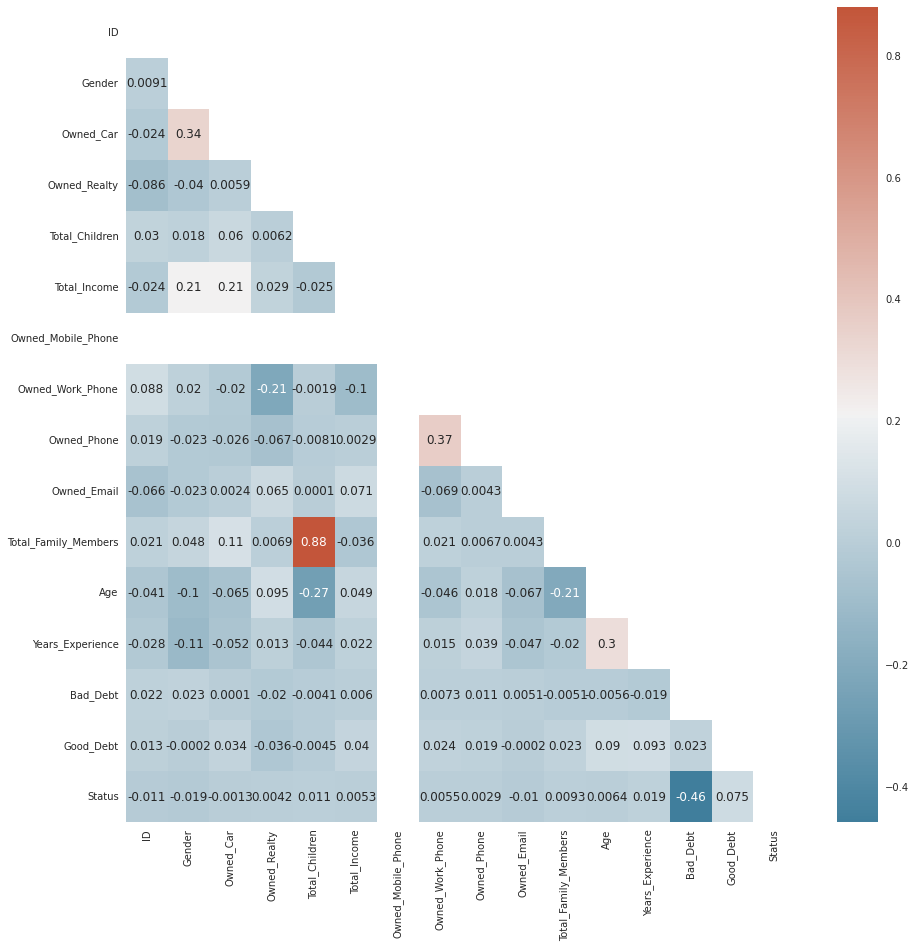

In [75]:
f, ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = df.corr().round(4)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap)

# Modeling

### Test data splitting for evalution

In [62]:
df_train = df.sample(frac=0.9, random_state=123)
df_test = df.drop(df_train.index)

df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_test.shape))

Data for Modeling: (21762, 21)
Unseen Data For Predictions: (2418, 21)


### Setting-up PyCaret

In [63]:
stp = setup(data = df_train, 
            target = 'Status',
            train_size = 0.8,
            categorical_features = ['Gender','Owned_Car','Owned_Realty',
                                    'Income_Type','Education_Type','Family_Status',
                                    'Housing_Type','Owned_Mobile_Phone','Owned_Work_Phone',
                                    'Owned_Phone','Owned_Email','Job_Title'], 
            ignore_features = ['ID', 'Good_Debt', 'Bad_Debt'],
            fix_imbalance = True,
            session_id=123)

,Description,Value
0,session_id,123
1,Target,Status
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(21762, 21)"
5,Missing Values,False
6,Numeric Features,3
7,Categorical Features,14
8,Ordinal Features,False
9,High Cardinality Features,False


### Model Comparison

In [64]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9948,0.6252,0.9992,0.9956,0.9974,0.1814,0.2183,16.9810
gbc,Gradient Boosting Classifier,0.9947,0.5542,0.9993,0.9954,0.9973,0.1163,0.1324,4.6420
lightgbm,Light Gradient Boosting Machine,0.9945,0.6555,0.9989,0.9956,0.9972,0.1617,0.1964,0.6730
rf,Random Forest Classifier,0.9944,0.6459,0.9988,0.9956,0.9972,0.1612,0.1908,1.7340
xgboost,Extreme Gradient Boosting,0.9944,0.6383,0.9988,0.9956,0.9972,0.1618,0.1964,25.8820
et,Extra Trees Classifier,0.9940,0.6756,0.9981,0.9959,0.9970,0.2169,0.2342,1.6530
dt,Decision Tree Classifier,0.9921,0.5999,0.9962,0.9958,0.9960,0.1761,0.1777,0.1490
ada,Ada Boost Classifier,0.9864,0.5772,0.9909,0.9954,0.9931,0.0653,0.0684,1.1030
knn,K Neighbors Classifier,0.9437,0.6155,0.9471,0.9961,0.9710,0.0347,0.0632,0.3930
lr,Logistic Regression,0.8915,0.5398,0.8955,0.9951,0.9269,0.0001,0.0011,0.5930


### Evaluation

In [65]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
dt = create_model('dt')

In [ ]:
evaluate_model(dt)

### Feature Importance

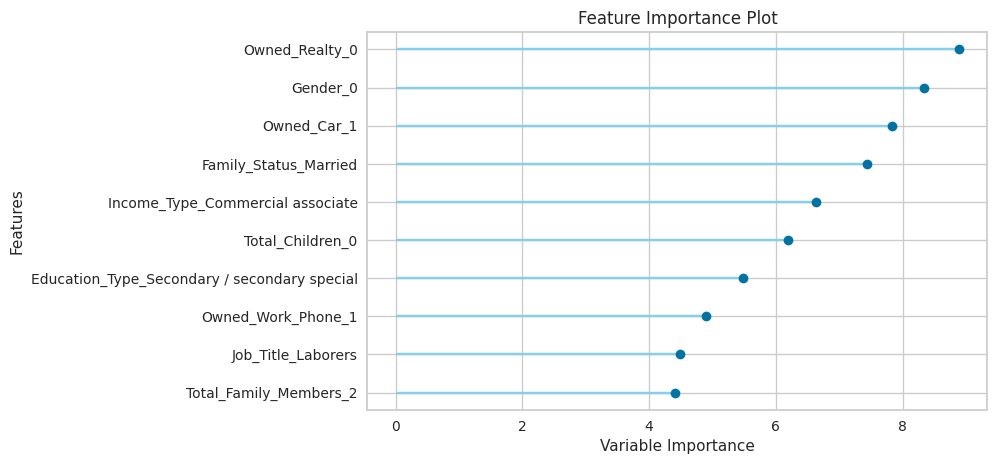

In [66]:
plot_model(best_model, plot='feature')

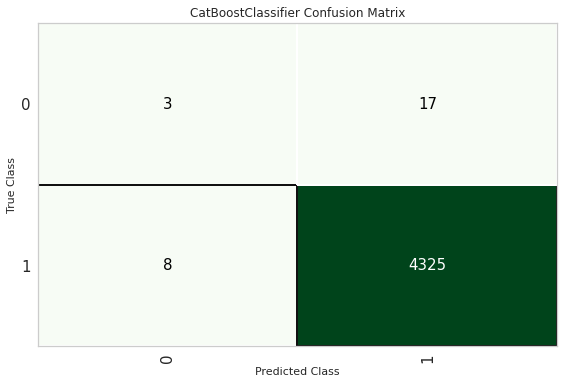

In [67]:
plot_model(best_model, plot = 'confusion_matrix')

### Best model extraction

In [69]:
ctboost = create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9954,0.5704,0.9994,0.9960,0.9977,0.1985,0.2484
1,0.9948,0.6877,0.9994,0.9954,0.9974,-0.0010,-0.0016
2,0.9960,0.6507,1.0000,0.9960,0.9980,0.3624,0.4705
3,0.9948,0.7791,0.9983,0.9965,0.9974,0.3975,0.4058
4,0.9937,0.6978,0.9988,0.9948,0.9968,-0.0019,-0.0024
5,0.9954,0.5227,1.0000,0.9954,0.9977,0.1992,0.3326
6,0.9943,0.4574,0.9994,0.9948,0.9971,-0.0010,-0.0017
7,0.9943,0.6439,0.9988,0.9954,0.9971,0.1645,0.1901
8,0.9943,0.8023,0.9988,0.9954,0.9971,0.1645,0.1901
9,0.9954,0.4398,0.9988,0.9965,0.9977,0.3313,0.3515


### Further Tuning

In [70]:
tune_ctboost = tune_model(ctboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9954,0.5622,0.9994,0.9960,0.9977,0.1985,0.2484
1,0.9948,0.7029,0.9994,0.9954,0.9974,-0.0010,-0.0016
2,0.9948,0.6221,1.0000,0.9948,0.9974,0.0000,0.0000
3,0.9954,0.7717,0.9988,0.9965,0.9977,0.4265,0.4452
4,0.9943,0.6665,0.9994,0.9948,0.9971,-0.0010,-0.0017
5,0.9948,0.5002,1.0000,0.9948,0.9974,0.0000,0.0000
6,0.9943,0.3666,0.9994,0.9948,0.9971,-0.0010,-0.0017
7,0.9943,0.6668,0.9988,0.9954,0.9971,0.1645,0.1901
8,0.9937,0.7270,0.9988,0.9948,0.9968,-0.0019,-0.0024
9,0.9954,0.4813,0.9988,0.9965,0.9977,0.3313,0.3515


### Prediction on unseen data

In [71]:
predict_model(tune_ctboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9949,0.6805,0.9991,0.9959,0.9975,0.1520,0.1806


,Total_Income,Age,Years_Experience,Gender_0,Owned_Car_1,Owned_Realty_0,Total_Children_0,Total_Children_1,Total_Children_2,Income_Type_Commercial associate,...,Job_Title_Secretaries,Job_Title_Security staff,Job_Title_Waiters/barmen staff,Total_Family_Members_1,Total_Family_Members_2,Total_Family_Members_3,Total_Family_Members_4,Status,Label,Score
0,459000.0,44.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.9852
1,112500.0,49.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.9994
2,202500.0,39.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0.9994
3,270000.0,37.0,7.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0.9995
4,180000.0,39.0,10.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.9871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4348,157500.0,29.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.9978
4349,121500.0,28.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.9862
4350,112500.0,37.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.9862
4351,157500.0,42.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,0.9921


### Finalizing model (training on whole dataset)

In [72]:
model_final = finalize_model(tune_ctboost)
print(model_final)

In [78]:
predictions = predict_model(model_final, data=df_test)
predictions

,ID,Gender,Owned_Car,Owned_Realty,Total_Children,Total_Income,Income_Type,Education_Type,Family_Status,Housing_Type,...,Owned_Email,Job_Title,Total_Family_Members,Age,Years_Experience,Bad_Debt,Good_Debt,Status,Label,Score
0,5008826,0,1,0,0,130500.0,Working,Incomplete higher,Married,House / apartment,...,0,Accountants,2,30.0,4.0,7,23,1,1,0.9841
1,5008832,0,0,1,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Laborers,2,28.0,5.0,2,33,1,1,0.9986
2,5008843,1,0,1,1,405000.0,Commercial associate,Higher education,Married,House / apartment,...,0,Managers,3,33.0,6.0,0,30,1,1,0.9994
3,5008860,0,1,1,2,135000.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Laborers,4,44.0,9.0,0,4,1,1,0.9993
4,5008864,0,1,1,2,135000.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Laborers,4,44.0,9.0,0,3,1,1,0.9993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2413,5150465,0,1,1,1,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Core staff,3,39.0,1.0,0,11,1,1,0.9982
2414,5150475,1,1,1,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,...,0,Laborers,2,30.0,4.0,0,44,1,1,0.9927
2415,5150482,0,1,1,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Core staff,3,30.0,5.0,0,18,1,1,0.9983
2416,5150484,0,1,1,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,Core staff,3,30.0,5.0,0,13,1,1,0.9983


### Saving model as a pickle for deployment

In [77]:
save_model(model_final,'PyCaret_model_280122')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['Gender',
                                                             'Owned_Car',
                                                             'Owned_Realty',
                                                             'Income_Type',
                                                             'Education_Type',
                                                             'Family_Status',
                                                             'Housing_Type',
                                                             'Owned_Mobile_Phone',
                                                             'Owned_Work_Phone',
                                                             'Owned_Phone',
                                                             'Owned_Email',
                                                             'Job_Title'],
                          